# REPLICATION: DATA ANALYSIS

As mentioned in the README.md, the replication phase of this project aims at studying the influence of several variability factors of the original experiment. We selected two of them:
- LLM: we used another model, llama-3.3-70b-versatile, to generate 20 games against Stockfish. We then evaluate its ability to play legal moves.
- Variant: we made ChatGPT 3.5 turbo-instruct and Llama (same version) play Chess960 against Stockfish (13 and 20 games, respectively), to see if they are able to notice it (in the PGN headers) and play accordingly.

In [33]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 
import matplotlib.pyplot as plt
from jupyterChessPGN import JupyterChessPGN
import numpy as np
import chess
import chess.pgn
import io 

In [34]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-3.5-turbo-instruct
      
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_black = df[(df['black'] == model_name) & (df['result'] == '1-0')].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)


In [35]:
def display_game(game_folder: str):
    jc = JupyterChessPGN(os.path.join(game_folder, "game.pgn")) 
    jc.make_gamelist_menu()
    # first game of PGN file to init 
    jc.set_ith_game(0)
    jc.showUI(print_pgn=True)

In [36]:
def illegal_moves_analysis(df, model_name, filtering_rules=None):
    df = df.query(f"white == '{model_name}' or black == '{model_name}'")
    
    if filtering_rules is not None:
        print(f"ANALYSIS OF {model_name}, WITH '{filtering_rules}':")
        df = df.query(filtering_rules)
    else:
        print(f"ANALYSIS OF {model_name}:")

    # Games lengths
    print(f"- {len(df)} total games, with lengths:")
    (df['nmoves'] / 2).plot(kind='box')
    plt.show()

    # Score
    df_legal_games = df.query("has_illegal == False")
    if len(df_legal_games) > 0:
        score = compute_score(df_legal_games, model_name=model_name)
        print(f"- Score {round(100*score, 2)}% for games with only legal moves")
    
    score, t = compute_score(df, model_name=model_name, percentage=False)
    tot = len(df)
    print(f"Score {round(100*(score/tot), 2)}% for all games i.e. {score}/{tot}, being legal or illegal (illegal move = loss)")

    # Number of illegal games & enum
    vals = df['has_illegal'].value_counts()
    ntot = vals.get(True, 0) + vals.get(False, 0)
    illegal_percentage = round((vals.get(True, 0)/ntot)*100) if ntot else 0
    print(f"- Out of {ntot} games, {vals.get(False, 0)} were legal games and {vals.get(True, 0)} were illegal games, hence {illegal_percentage}% of illegal games.")

    print("Illegal moves are:")
    print(df.query("has_illegal == True")['illegal_move'].value_counts().to_markdown())

In [75]:
def parse_result(row, parse_method_if_illegal: callable):
    if row["has_illegal"] is True:
        return parse_method_if_illegal(row)
    
    result_for_white = 1 if row["result"] == "1-0" else 0 if row["result"] == "0-1" else 0.5
    if row['white_elo'] == '?':
        return result_for_white
    else:
        return 1 - result_for_white

def compute_elo_against_stockfish(df, model_name, computing_method: callable, parse_method_if_illegal:callable, filtering_rules=None):
    df = df.query(f"random_engine == False and (white == '{model_name}' or black == '{model_name}')")
    
    if filtering_rules is not None:
        print(f"ELO OF {model_name}, WITH '{filtering_rules}':")
        df = df.query(filtering_rules)
    else:
        print(f"ELO OF {model_name}:")
        
    # Prepare the dataframe for elo calculation
    new_df = pd.DataFrame()
    new_df["opponent_elo"] = df.apply(lambda row: float(row['white_elo'] if row['white_elo'] != '?' else row['black_elo']), axis=1)
    new_df["result"] = df.apply(lambda row: parse_result(row, parse_method_if_illegal), axis=1)

    elo = round(computing_method(new_df))
    print(elo)

def fide_perf_rating(games: pd.DataFrame):
    """
    required columns: opponent_elo and result (0 for loss, 0.5 for draw, 1 for win)
    https://en.wikipedia.org/wiki/Elo_rating_system
    """
    def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01, 0.0],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -422, -444, -470, -501, -538, -589, -677, -800]
        }
        
        # Convert to DataFrame
        df_fide = pd.DataFrame(data)
        
        rscore = round(score, 2)
        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp
    
    elo = games["opponent_elo"].mean() + lookup_fide_table(games["result"].mean())
    return elo

def illegal_implies_loss(row):
    return 0

In [37]:
# To load data from an existing dataframe:
# df = pd.read_csv("analysis_files/games_replication_db.csv")

# Store the games in a pandas dataframe

In [49]:
# If you are using the notebook manually: set the correct folder in the default_folder variable
# If the notebook is used for automatic html generation by docker: infer it from the GPTCHESS_GAMES_FILE environment variable

default_folder = "games_replication"

games_compressed_file = os.getenv("GPTCHESS_GAMES_FILE")

if games_compressed_file is None:
    games_folder = default_folder
else:
    games_folder = os.path.join(os.getenv("WORKDIR"),
                                os.path.basename(games_compressed_file).split(".")[0]
                               )
    
print(f"Folder used: {games_folder}")

Folder used: games_replication


### Retrieve information from each game

In [50]:
# list each folder of folder "games"
# get all folders
folders = glob.glob(games_folder + "/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value

    # number of moves
    game_length = len(list(game.mainline_moves()))

    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        # print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dataframe

    game_data = pd.DataFrame([{"white": white, "black": black, "white_elo": white_elo, "black_elo": black_elo,
                         "result": result, "nmoves" : game_length, "nstarting_move": nmove_value, "pgn_base" : pgn_base,
                         "temperature" : temperature, "random_engine" : random_engine, "has_illegal" : has_illegal,
                         "illegal_move" : illegal_move, "folder_name" : folder}])
    df = pd.concat([df, game_data], ignore_index=True) if len(df) > 0 else game_data


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...



illegal san: 'O-O' in qrnnbkrb/pppppppp/8/8/8/8/PPPPPPPP/QRNNBKRB w - - 0 1 while parsing <Game at 0x7e8743f87f40 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>
illegal san: 'O-O' in qrnnbkrb/pppppp1p/6p1/8/8/6P1/PPPPPP1P/QRNNBKRB w - - 0 2 while parsing <Game at 0x7e8743f9d060 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>


In [51]:
# include a column indicating whether this is a normal chess game or chess960

def is960(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    return g.headers.is_chess960()

def get_moves(folder_name):
    with open(folder_name + "/game.pgn") as pgn:
        g = chess.pgn.read_game(io.StringIO(pgn.read()))
        return g.mainline_moves()

df["chess960"] = df["pgn_base"].apply(is960)
df["moves"] = df["folder_name"].apply(get_moves)

illegal san: 'O-O' in qrnnbkrb/pppppppp/8/8/8/8/PPPPPPPP/QRNNBKRB w - - 0 1 while parsing <Game at 0x7e873b31eec0 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>
illegal san: 'O-O' in qrnnbkrb/pppppp1p/6p1/8/8/6P1/PPPPPP1P/QRNNBKRB w - - 0 2 while parsing <Game at 0x7e873a3dfdf0 ('Stockfish' vs. 'gpt-3.5-turbo-instruct', '????.??.??' at '?')>


In [52]:
print(f"-> {len(df)}/{len(folders)} games retrieved")

-> 58/58 games retrieved


### Result

In [53]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,chess960,moves
0,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,85,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,1-0,games_replication/game341afeb0-1a45-4134-8853-...,False,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Bxc6 dxc6 5. ...
1,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,11,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxd4,games_replication/game7a75ff64-8bf2-44b8-a82b-...,True,1. c4 c6 2. h4 d5 3. b3 e5 4. Ned3 Nf6 5. Nxe5...
2,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,121,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,1-0,games_replication/game46b90389-512f-4e60-8167-...,False,1. Nf3 Nf6 2. d4 d5 3. Bf4 c5 4. dxc5 Nc6 5. a...
3,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,9,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Nf6,games_replication/game90832e60-aeb0-4558-b1e7-...,True,1. c4 c6 2. Ncd3 d5 3. c5 Nc7 4. h4 h5 5. Ne5
4,Stockfish,gpt-3.5-turbo-instruct,1954,?,*,1,1,"[Event ""World Fischer Random 2024""]\n[Site ""Lo...",0.0,False,True,Nc6,games_replication/game18af3ca6-7836-4c73-a465-...,True,1. Ncd3


In [82]:
# Frequencies based on piece colors
for variant in ("Normal", "Chess960"):
    chess960 = variant == "Chess960"
    
    df_variant = df[df["chess960"] == chess960]
    players = set(df_variant["white"].unique()).union(set(df_variant["black"].unique())).difference({"Stockfish"})
    color_breakdown = {}
    for player in players:
        white_count = df_variant[df_variant['white'] == player].shape[0]
        black_count = df_variant[df_variant['black'] == player].shape[0]
        color_breakdown[player] = {'white': white_count, 'black': black_count, 'total': white_count+black_count}

    print(f"- Variant {variant}:")
    print(pd.DataFrame(color_breakdown), "\n")

- Variant Normal:
       gpt-3.5-turbo-instruct  llama-3.3-70b-versatile
white                       0                        0
black                       5                       20
total                       5                       20 

- Variant Chess960:
       gpt-3.5-turbo-instruct  llama-3.3-70b-versatile
white                       0                        0
black                      13                       20
total                      13                       20 



In [55]:
df.to_csv(f"analysis_files/{os.path.basename(games_folder)}_db.csv")
print(f"Saved at analysis_files/{os.path.basename(games_folder)}_db.csv")

Saved at analysis_files/games_replication_db.csv


# Llama against Stockfish: standard chess

In [56]:
df_normal = df.query("chess960 == False")

ANALYSIS OF llama-3.3-70b-versatile:
- 20 total games, with lengths:


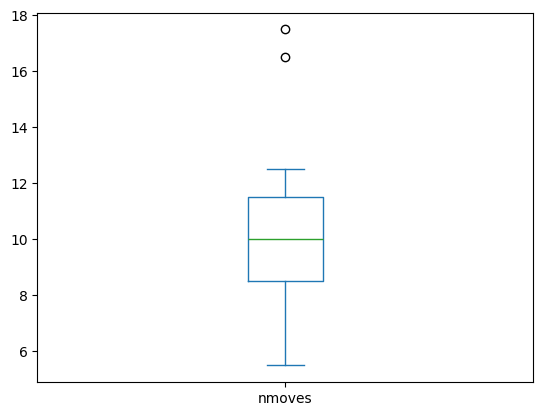

Score 0.0% for all games i.e. 0.0/20, being legal or illegal (illegal move = loss)
- Out of 20 games, 0 were legal games and 20 were illegal games, hence 100% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Qe7            |      10 |
| bxc6           |       2 |
| b5             |       1 |
| Be7            |       1 |
| Kxe2           |       1 |
| Nxb4           |       1 |
| Bxe2           |       1 |
| Kd8            |       1 |
| Nxc5           |       1 |
| Qxe2           |       1 |


In [57]:
illegal_moves_analysis(df_normal, "llama-3.3-70b-versatile")

These games seem to indicate that Llama is not able to play a full legal chess game.

Contrary to GPT 3.5-turbo-instruct, the Llama model doesn't make an illegal move by "resigning" the game (1-0), but seems to produce "real" illegal moves. Interestingly, the "Qe7" illegal move is particularly recurrent in our (small!) dataset. Here is a few games featuring it:

In [58]:
df_normal_Qe7 = df_normal.query("illegal_move == 'Qe7'")
len(df_normal_Qe7)

10

In [60]:
type(df_normal_Qe7)

pandas.core.frame.DataFrame

In [63]:
display_game(df_normal_Qe7["folder_name"].iloc[0])

[Event "llama-3.3-70b-versatile vs Stockfish"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "Stockfish"]
[Black "llama-3.3-70b-versatile"]
[Result "*"]
[WhiteElo "1954"]
[BlackElo "?"]
[UnknownSAN "Qe7"]

1. d4 d5 2. Nd2 Nf6 3. e3 e6 4. Ngf3 Be7 5. b3 b6 6. Bd3 c5 7. O-O Nc6 8. Qe2 a6 9. Bb2 *


Dropdown(description='Game:', options=(('Stockfish-llama-3.3-70b-versatile * (g 1)', 0),), value=0)

Output()

Output()

In [64]:
display_game(df_normal_Qe7["folder_name"].iloc[1])

[Event "llama-3.3-70b-versatile vs Stockfish"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "Stockfish"]
[Black "llama-3.3-70b-versatile"]
[Result "*"]
[WhiteElo "1954"]
[BlackElo "?"]
[UnknownSAN "Qe7"]

1. e4 e5 2. d4 exd4 3. Bc4 Nf6 4. Qxd4 Nc6 5. Qd3 d6 6. Nf3 Be7 7. Nc3 a6 8. a3 b5 9. Bd5 Na5 10. Bxa8 *


Dropdown(description='Game:', options=(('Stockfish-llama-3.3-70b-versatile * (g 1)', 0),), value=0)

Output()

Output()

In [66]:
display_game(df_normal_Qe7["folder_name"].iloc[2])

[Event "llama-3.3-70b-versatile vs Stockfish"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "Stockfish"]
[Black "llama-3.3-70b-versatile"]
[Result "*"]
[WhiteElo "1954"]
[BlackElo "?"]
[UnknownSAN "Qe7"]

1. Nf3 d5 2. d4 Nf6 3. e3 e6 4. c4 c6 5. Nc3 b6 6. Qc2 Be7 7. a3 a6 8. g4 h6 9. Rg1 g5 10. h4 gxh4 11. Bd2 Bb7 12. g5 hxg5 13. Nxg5 Nbd7 14. Nxf7 Kxf7 15. Qg6+ Kf8 16. e4 dxe4 17. Be2 *


Dropdown(description='Game:', options=(('Stockfish-llama-3.3-70b-versatile * (g 1)', 0),), value=0)

Output()

Output()

The recurrent pattern here is that the LLM didn't acknowledge the black bishop on e7, obstructing black's queen from going to that square.

# GPT 3.5 turbo-instruct and Llama against Stockfish: Chess 960

In [77]:
df_960 = df.query("chess960 == True")

### GPT 3.5-turbo-instruct

ANALYSIS OF gpt-3.5-turbo-instruct:
- 13 total games, with lengths:


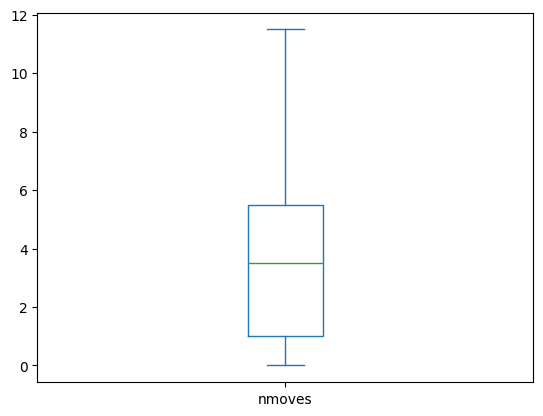

- Score 0.0% for games with only legal moves
Score 0.0% for all games i.e. 0.0/13, being legal or illegal (illegal move = loss)
- Out of 13 games, 1 were legal games and 12 were illegal games, hence 92% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Nf6            |       2 |
| Nc6            |       2 |
| Qxd4           |       1 |
| Nf8            |       1 |
| Bg7            |       1 |
| 1.             |       1 |
| -O             |       1 |
| Bg4            |       1 |
| O-O            |       1 |
| Kxd8           |       1 |


In [83]:
illegal_moves_analysis(df_960, "gpt-3.5-turbo-instruct")

It appears that, among the few games that were generated, only the following one was totally legal.

In [84]:
display_game(df_960.query("black=='gpt-3.5-turbo-instruct' and has_illegal == False")["folder_name"].iloc[0])

[Event "gpt-3.5-turbo-instruct vs Stockfish"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "Stockfish"]
[Black "gpt-3.5-turbo-instruct"]
[Result "1-0"]
[FEN "bqnbnrkr/pppppppp/8/8/8/8/PPPPPPPP/BQNBNRKR w - - 1 1"]
[SetUp "1"]
[WhiteElo "1954"]
[BlackElo "?"]

1. h4 g6 2. h5 gxh5 3. b3 Nf6 4. Rh3 d5 5. Bxf6 exf6 6. Rg3# 1-0


Dropdown(description='Game:', options=(('Stockfish-gpt-3.5-turbo-instruct 1-0 (g 1)', 0),), value=0)

Output()

Output()

We can notice that no move would have been illegal in regular chess either: this game does not really prove the LLM can detect that it is Fischer Random.

### llama-3.3-70b-versatile

ANALYSIS OF llama-3.3-70b-versatile:
- 20 total games, with lengths:


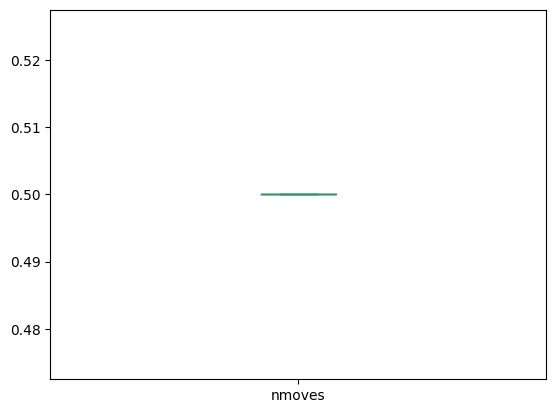

Score 0.0% for all games i.e. 0.0/20, being legal or illegal (illegal move = loss)
- Out of 20 games, 0 were legal games and 20 were illegal games, hence 100% of illegal games.
Illegal moves are:
| illegal_move   |   count |
|:---------------|--------:|
| Since          |      12 |
| A              |       5 |
| The            |       3 |


In [85]:
illegal_moves_analysis(df_960, "llama-3.3-70b-versatile")

As you can see, despite indicating clearly what we want in the role given to the model, Llama doesn't even try to complete the PGN.